In [69]:
import json
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import statsmodels
import csv
import pickle

# Processing Data from PostGRES Output

Creating a single JSON file for each participant from PostGRES data that contains a single list of all participant data

In [70]:
fileprefix = "full_1" # pilot_[1,2,4]
filepath = '../results/{}_results.json'.format(fileprefix)


In [71]:
with open(filepath, 'r') as f:
    all_data = json.load(f)

In [72]:
part_data = {}

count = 0
for participant in all_data['values']:
    count+=1
    print(count, participant[2])
    try:
        part_object = json.loads(participant[17])
        part_object["Beginhit"] = participant[11]
        part_object["Beginexp"] = participant[12]
        part_object["Endhit"] = participant[13]
        part_object["psiturkStatus"] = participant[15]
        part_object["browser"] = participant[5]
        part_object["platform"] = participant[6]
        part_object["language"] = participant[7]
        
        if part_object["workerId"].startswith("debug"):
            continue

        part_data[part_object["workerId"]] = part_object
        with open('../results/{}_{}.json'.format(fileprefix, part_object['workerId']), 'w') as fw:
            json.dump(part_object, fw)
    except:
        print("Fail")
        continue;

1 5aea25acd9f2be0001933493
2 6163f732b3f62685da49d2e6
3 61320a26c3013321c8d54600
4 60b82d1a568805f9b20e5167
5 611fbfae3ce6f9dfaa946f69
6 64b748a867cc1c1eba234870
7 614b1928b54d93b19437d4f0
8 debugnIqhh
9 6151f4af8af3c53428216391
10 6164cdedc4b526b72d7b96a1
11 5f3a4444b12c9a5f76eca182
12 6155aae55300ebb347b7a578
13 61085294d9f09294ecd7e911
14 debugQ80TR
15 5e9375259c9687000b26ec11
16 5f14e794a89ac35a3f89801d
17 6310aadd077de00d527415bf
18 6103e1f548891c55b3c25715
19 5e2df2855e01ef3e5d01ab58
20 6101c49c2727ad36a6c593af
21 5d3e47ba29130a00015cd41d
22 648833efc6497e4334a8f990
23 611cad8a4a2f32e0ab56c282
24 612bde3f08ed524fa47c2ac2
25 6104921c0cd5d47f9ec1d719
26 6138c4f2d86575a7ec137709
27 5eb3a734d249ac18a413063a
28 591a3d023d3e900001045994
29 6136aa846e80ebd7daf6e148
30 6475ff9e12b4b23f18f4503c
31 647e5108e966c7cb5ec837cc
32 5c7eb988ac63960015004d03
33 57262ce40e21cd0008ce5d22
34 61688109ef9dda2f9c38765a
35 57507e67fcaa630007cb9ad2
36 5f0633361308dd16f7f4039c
37 60e579897ebd06b1537eb223
3

In [73]:
part_data.keys()


dict_keys(['5aea25acd9f2be0001933493', '6163f732b3f62685da49d2e6', '61320a26c3013321c8d54600', '60b82d1a568805f9b20e5167', '611fbfae3ce6f9dfaa946f69', '64b748a867cc1c1eba234870', '614b1928b54d93b19437d4f0', '6151f4af8af3c53428216391', '6164cdedc4b526b72d7b96a1', '5f3a4444b12c9a5f76eca182', '6155aae55300ebb347b7a578', '61085294d9f09294ecd7e911', '5e9375259c9687000b26ec11', '5f14e794a89ac35a3f89801d', '6310aadd077de00d527415bf', '6103e1f548891c55b3c25715', '5e2df2855e01ef3e5d01ab58', '6101c49c2727ad36a6c593af', '5d3e47ba29130a00015cd41d', '648833efc6497e4334a8f990', '611cad8a4a2f32e0ab56c282', '612bde3f08ed524fa47c2ac2', '6104921c0cd5d47f9ec1d719', '6138c4f2d86575a7ec137709', '5eb3a734d249ac18a413063a', '591a3d023d3e900001045994', '6136aa846e80ebd7daf6e148', '6475ff9e12b4b23f18f4503c', '647e5108e966c7cb5ec837cc', '5c7eb988ac63960015004d03', '57262ce40e21cd0008ce5d22', '61688109ef9dda2f9c38765a', '57507e67fcaa630007cb9ad2', '5f0633361308dd16f7f4039c', '60e579897ebd06b1537eb223', '61167a7a

# Reading Data from Already Created Participant Data Files

In [6]:
fileprefix = "pilot_3" # pilot_#, final
datafolder = '../results/'

all_part_files = [filename for filename in os.listdir(datafolder) if filename.startswith(fileprefix) and 'results' not in filename]
all_part_paths = [datafolder + filename for filename in all_part_files]

In [7]:
part_data = {}
for file in all_part_paths:
    with open(file, 'r') as f:
        participant = json.load(f)
        part_data[participant["workerId"]] = participant



In [74]:
len(part_data.keys())

42

# Analyzing Trial Data

Create a list of objects, one for each participant's data

In [209]:
part_stats_dicts = []
for participant in part_data.values():
    try:
        beginhit = datetime.datetime.strptime(participant['Beginhit'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        beginhit = None
    try:
        endhit = datetime.datetime.strptime(participant['Endhit'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        endhit = None
    try:    
        beginexp = datetime.datetime.strptime(participant['Beginexp'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        beginexp = None
    
    try:
        hitLength = (endhit-beginhit).seconds
    except TypeError:
        hitLength = None
    
    try:
        expLength = (endhit-beginexp).seconds
    except TypeError:
        expLength = None
        
    numPracTrials = 0
    trialLengths = []
    trialScores = []
    rewardsWithheld = []
    effort = "-1"
    age = None
    gender = None
    colorblind = None
    print(participant['workerId'])
    try:
        firstTrialStamp = participant['data'][0]['dateTime']
        lastTrialStamp = participant['data'][-1]['dateTime']
    except:
        print("No data")
        continue
    if hitLength is None:
        hitLength = (lastTrialStamp - firstTrialStamp) / 1000
    if expLength is None:
        expLength = (lastTrialStamp - firstTrialStamp) / 1000
        
    mdp_timestamps = {
        "start" : 0,
        "end" : 0,
        "done": False
    }
    current_state = "stroop_1"
    last_trial = participant['data'][0]
    finishHITReached = False
    demographicsAvailable = False
    feedback = ""
    alreadyParticipated = ""
    comments = ""
    whatStrategy = ""
    clicksL1 = []
    firstLevelAns = {}
    clickStratsValid = True
    strategyImprove = ""
    difficult = ""
    num_correct_sequences = 0
    final_quiz_responses = None
    for idx, trial in enumerate(participant['data']):
        trial_type = trial['trialdata']['trial_type']
        try:
            trial_id = str(trial['trialdata']['trial_id'])
        except KeyError:
            trial_id = ""
        
        if participant['workerId'] == "5eb40f1f0d916d20d9db9144":
            print("{}\t{}\t{}".format(trial_type, trial_id, idx))
            
        if trial_id.startswith("mouselab_instructions_1") and not mdp_timestamps["done"]:
            mdp_timestamps["done"] = True
            mdp_timestamps["start"] = trial['dateTime']
        
        if "num_correct_sequences" in trial['trialdata']:
            num_correct_sequences = trial['trialdata']['num_correct_sequences']
        
        if trial_id.startswith("final_quiz"):
            mdp_timestamps["end"] = trial['dateTime']
            final_quiz_responses = trial['trialdata']['response']

        if trial_id.startswith("self_report_2"):
            firstLevelAns = trial['trialdata']['response']
        
        if trial_id.startswith("finish_fail"):
            feedback = trial['trialdata']['response']['Q0']
            age = trial['trialdata']['response']['Q1']
            gender = trial['trialdata']['response']['Q2']
            colorblind = trial['trialdata']['response']['Q3']
            comments = trial['trialdata']['response']['Q4']
            demographicsAvailable = True
            
        if trial_type == 'mouselab-mdp':
            if trial_id.startswith('practice'):
                numPracTrials += 1
            else:
                trialLengths.append(trial['trialdata']['trialTime'])
                
                trialScores.append(trial['trialdata']['score'])
                rewardsWithheld.append(trial['trialdata']['withholdReward'])
                clicks = trial['trialdata']['queries']['click']['state']['target']
                cL1 = len([c for c in clicks if int(c) in [1,12,23]])
                clicksL1.append(cL1)
        if trial_type == 'survey-html-form':
            
            if 'effort' in trial['trialdata']['response']:
                effort = trial['trialdata']['response']['effort']
                age = trial['trialdata']['response']['age']
                gender = trial['trialdata']['response']['gender']
                colorblind = trial['trialdata']['response']['colorblind']
                demographicsAvailable = True
        
        elif trial_type == 'survey-text':
            if trial_id.startswith("self_report"):
                whatStrategy = trial['trialdata']['response']['Q0']
                strategyImprove = trial['trialdata']['response']['Q1']
                difficult = trial['trialdata']['response']['Q2']
            
            elif not trial_id.startswith("answer"):
                #print(trial['trialdata'])
                feedback = trial['trialdata']['response']['Q0']
                alreadyParticipated = trial['trialdata']['response']['Q1']
                comments = trial['trialdata']['response']['Q2']
        
        if trial_type == 'html-button-response':
            if "Finish HIT" in trial['trialdata']['stimulus']:
                finishHITReached = True
        last_trial = trial
    
    # Checking if click strategies are invalid
    if firstLevelAns:
        # Criteria 1: clicks made on first level nodes on more than 10% of the trials
        madeL1Clicks = sum([bool(c) for c in clicksL1])/len(clicksL1) >= 0.10
        # Criteria 2: did not pay attention to the values at the first level - average agreement with
        #   negative statements greater than 2 (indifference)
        
        # Assessed by answers to Q5 and Q6
        possible_answers = ["Strongly disagree", "Disagree", "Neither disagree nor agree", "Agree", "Strongly agree"]
        
        # "... I did pay attention"
        scoreQ5 = possible_answers.index(firstLevelAns["Q5"])
        # "... I did NOT pay attention"
        scoreQ6 = possible_answers.index(firstLevelAns["Q6"])
        adj_scoreQ6 = len(possible_answers) - scoreQ6 - 1
        
        avg_attn_score = (scoreQ5 + adj_scoreQ6) / 2
        clickStratsValid = not madeL1Clicks or (avg_attn_score >= 2)
    dropoutPoint = None
    for obj, type_ in zip([mdp_timestamps], ["mdp"]):
        if obj["start"] > 0 and obj["end"] == 0:
            
            dropoutPoint = type_
            obj["end"] = lastTrialStamp
            
    if not dropoutPoint:
        if len(trialLengths) == 0:
            dropoutPoint = "beginning"
        elif not finishHITReached:
            dropoutPoint = "finishHIT"
            
    if dropoutPoint:
        print(participant['workerId'], dropoutPoint)
    part_stats_dict = {
        "workerId": participant['workerId'],
        "Beginhit": beginhit,
        "Endhit": endhit,
        "Beginexp": beginexp,
        "psiturkStatus" : participant["psiturkStatus"],
        "browser" : participant["browser"],
        "platform" : participant["platform"],
        "language" : participant["language"],
        "hitLength": hitLength,
        "expLength": expLength,
        "totalLengthSum": (lastTrialStamp - firstTrialStamp) / 1000,
        "numQuizAttempts": numPracTrials / 2,
        "trialLengths": trialLengths,
        "trialScores" : trialScores,
        "numTrialsCompleted": len(trialLengths),
        "rewardsWithheld": rewardsWithheld,
        "effort": effort,
        "clicksL1": clicksL1,
        "age":age,
        "colorblind":colorblind,
        "gender":gender,
        "condition": participant['condition'],
        "mouselabLength" : (mdp_timestamps["end"] - mdp_timestamps["start"]) / 1000,
        "dropoutPoint" : dropoutPoint,
        "feedback": feedback,
        "alreadyParticipated": alreadyParticipated,
        "comments": comments,
        "finishHITReached": finishHITReached,
        "demographicsAvailable": demographicsAvailable,
        "whatStrategy": whatStrategy,
        "strategyImprove": strategyImprove,
        "difficult": difficult,
        "firstLevelAns": firstLevelAns,
        "num_correct_sequences": num_correct_sequences,
        "final_quiz_responses": final_quiz_responses,
        "clickStratsValid": clickStratsValid
    }
    if 'questiondata' in participant and 'final_score' in participant['questiondata']:
        part_stats_dict['finalScore'] = participant['questiondata']['final_score']
    else:
        part_stats_dict['finalScore'] = sum([score for (score, withheld) in zip(trialScores, rewardsWithheld) if not withheld])
    
    part_stats_dict["expLengthSum"] = part_stats_dict["mouselabLength"]
    part_stats_dict["expLengthDiff"] = part_stats_dict["expLengthSum"] - part_stats_dict["expLength"]
    if len(trialLengths) > 0:
        part_stats_dict["averageTrialLength"] = sum(trialLengths) / len(trialLengths)
        part_stats_dict["propWithheld"] = sum(rewardsWithheld) / len(rewardsWithheld)
        
    part_stats_dicts.append(part_stats_dict)
    

5aea25acd9f2be0001933493
6163f732b3f62685da49d2e6
61320a26c3013321c8d54600
60b82d1a568805f9b20e5167
0.025 False False
611fbfae3ce6f9dfaa946f69
64b748a867cc1c1eba234870
64b748a867cc1c1eba234870 mdp
614b1928b54d93b19437d4f0
6151f4af8af3c53428216391
6151f4af8af3c53428216391 mdp
6164cdedc4b526b72d7b96a1
0.6 True True
5f3a4444b12c9a5f76eca182
0.0 False True
6155aae55300ebb347b7a578
0.05 False True
61085294d9f09294ecd7e911
5e9375259c9687000b26ec11
5e9375259c9687000b26ec11 mdp
5f14e794a89ac35a3f89801d
0.55 True True
6310aadd077de00d527415bf
0.05 False True
6103e1f548891c55b3c25715
0.125 True True
5e2df2855e01ef3e5d01ab58
6101c49c2727ad36a6c593af
0.725 True True
5d3e47ba29130a00015cd41d
648833efc6497e4334a8f990
648833efc6497e4334a8f990 finishHIT
611cad8a4a2f32e0ab56c282
612bde3f08ed524fa47c2ac2
0.8 True True
6104921c0cd5d47f9ec1d719
1.0 True True
6138c4f2d86575a7ec137709
0.2 True True
5eb3a734d249ac18a413063a
591a3d023d3e900001045994
6136aa846e80ebd7daf6e148
0.0 False True
6475ff9e12b4b23f18f4

In [185]:
stats_df = pd.DataFrame(part_stats_dicts)
print(len(stats_df))
filter_cols = ["workerId", "Beginhit", "hitLength", "expLength", "condition", "numQuizAttempts", "numTrialsCompleted", "mouselabLength", "finalScore", "num_correct_sequences", "dropoutPoint", "finishHITReached", "psiturkStatus", "effort", "demographicsAvailable"]
stats_df[filter_cols]

41


,workerId,Beginhit,hitLength,expLength,condition,numQuizAttempts,numTrialsCompleted,mouselabLength,finalScore,num_correct_sequences,dropoutPoint,finishHITReached,psiturkStatus,effort,demographicsAvailable
0,5aea25acd9f2be0001933493,2023-08-01 16:15:59.779661,2617.000,2609.000,0,2.0,40,2106.178,2088.40,0,None,True,3,0,True
1,6163f732b3f62685da49d2e6,2023-08-01 14:28:56.874935,3367.000,3345.000,0,4.0,40,2281.027,1160.40,0,None,True,3,0,True
2,61320a26c3013321c8d54600,2023-08-01 14:43:02.227109,1589.000,1566.000,0,1.0,40,1022.288,-126.00,0,None,True,3,0,True
3,60b82d1a568805f9b20e5167,2023-08-01 14:35:44.373541,2599.000,2577.000,1,2.0,40,1866.767,308.25,0,None,True,3,0,True
4,611fbfae3ce6f9dfaa946f69,2023-08-01 14:53:01.169461,2115.000,2084.000,0,1.0,40,1223.915,-131.00,0,None,True,3,0,True
5,64b748a867cc1c1eba234870,2023-08-01 14:34:14.259557,145.433,145.433,0,0.0,0,0.000,0.00,0,mdp,False,6,-1,False
6,614b1928b54d93b19437d4f0,2023-08-01 14:30:04.179068,5403.000,1511.000,0,1.0,40,1069.733,-25.00,0,None,True,3,0,True
7,6151f4af8af3c53428216391,2023-08-01 14:25:35.058110,852.070,852.070,0,3.0,0,506.700,0.00,0,mdp,False,6,-1,False
8,6164cdedc4b526b72d7b96a1,2023-08-01 14:29:17.102442,3098.000,3087.000,1,2.0,40,2195.749,1966.65,0,None,True,3,0,True
9,5f3a4444b12c9a5f76eca182,2023-08-01 14:26:48.129820,1451.000,1434.000,1,1.0,40,1064.319,1987.35,0,None,True,3,1,True


In [186]:
# Filter those who dropped out immediately

immediate_drops = stats_df.loc[(stats_df.dropoutPoint == "beginning")]
print(len(immediate_drops))
immediate_drops

1


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,difficult,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
39,611d1b663a5c2ab412850a1c,2023-08-01 14:29:17.475007,NaT,2023-08-01 14:29:34.280621,6,chrome,linux,en-ZA,0.0,0.0,...,,{},0,None,True,0.0,0.0,0.0,NaN,NaN


In [187]:
no_immediate_drops = stats_df.loc[(stats_df.dropoutPoint != "beginning")]
print(len(no_immediate_drops))
no_immediate_drops

40


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,difficult,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
0,5aea25acd9f2be0001933493,2023-08-01 16:15:59.779661,2023-08-01 16:59:37.546684,2023-08-01 16:16:07.672624,3,chrome,windows,en-GB,2617.000,2609.000,...,it was hard to find where the highest might be...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,2088.40,2106.178,-502.822,40382.650000,0.0
1,6163f732b3f62685da49d2e6,2023-08-01 14:28:56.874935,2023-08-01 15:25:04.234710,2023-08-01 14:29:19.216528,3,chrome,windows,en-US,3367.000,3345.000,...,It was not that difficult but I needed to be...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,1160.40,2281.027,-1063.973,25373.800000,0.0
2,61320a26c3013321c8d54600,2023-08-01 14:43:02.227109,2023-08-01 15:09:31.444686,2023-08-01 14:43:24.500066,3,chrome,windows,en-US,1589.000,1566.000,...,It was very difficult to find the right node t...,{},0,"{'Q0': '$-16 to 16', 'Q1': '$-16 to $16', 'Q2'...",True,-126.00,1022.288,-543.712,21072.850000,0.0
3,60b82d1a568805f9b20e5167,2023-08-01 14:35:44.373541,2023-08-01 15:19:03.389869,2023-08-01 14:36:05.729837,3,chrome,windows,en-US,2599.000,2577.000,...,It wasnt difficult,"{'Q0': 'Agree', 'Q1': 'Neither disagree nor ag...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,308.25,1866.767,-710.233,21576.075000,0.0
4,611fbfae3ce6f9dfaa946f69,2023-08-01 14:53:01.169461,2023-08-01 15:28:16.197528,2023-08-01 14:53:32.076016,3,firefox,windows,en-US,2115.000,2084.000,...,I did find it difficult to improve my strategy...,{},0,"{'Q0': '$-88 to $88', 'Q1': '$-32 to $32', 'Q2...",True,-131.00,1223.915,-860.085,20417.375000,0.0
5,64b748a867cc1c1eba234870,2023-08-01 14:34:14.259557,NaT,2023-08-01 14:34:29.442632,6,chrome,linux,en-GB,145.433,145.433,...,,{},0,None,True,0.00,0.000,-145.433,NaN,NaN
6,614b1928b54d93b19437d4f0,2023-08-01 14:30:04.179068,2023-08-01 16:00:07.827458,2023-08-01 15:34:56.047466,3,chrome,windows,en-US,5403.000,1511.000,...,"Very, if you clicked the same node twice you c...",{},0,"{'Q0': '$-16 to 16', 'Q1': '$-32 to $32', 'Q2'...",True,-25.00,1069.733,-441.267,20485.475000,0.0
7,6151f4af8af3c53428216391,2023-08-01 14:25:35.058110,NaT,2023-08-01 14:25:55.489292,6,chrome,windows,en-US,852.070,852.070,...,,{},0,None,True,0.00,506.700,-345.370,NaN,NaN
8,6164cdedc4b526b72d7b96a1,2023-08-01 14:29:17.102442,2023-08-01 15:20:55.280462,2023-08-01 14:29:27.665730,3,chrome,windows,en-US,3098.000,3087.000,...,A little challenging. The time given for the n...,"{'Q0': 'Agree', 'Q1': 'Strongly disagree', 'Q2...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1966.65,2195.749,-891.251,35337.200000,0.0
9,5f3a4444b12c9a5f76eca182,2023-08-01 14:26:48.129820,2023-08-01 14:50:59.250683,2023-08-01 14:27:05.087157,3,chrome,windows,en-GB,1451.000,1434.000,...,There was some difficulty because its hard to ...,"{'Q0': 'Strongly disagree', 'Q1': 'Disagree', ...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1987.35,1064.319,-369.681,22826.900000,0.0


In [188]:
# Partial compensation rates

gbp_hourly = 6.00
secondly_rate = gbp_hourly / (3600)

In [189]:
# Early quitters - Psiturk status 6 or 2, and no quiz attempts completed

early_quitters = no_immediate_drops.loc[(no_immediate_drops.psiturkStatus == 6) & (no_immediate_drops.numQuizAttempts == 0)]
early_quitters.loc[:,'bonus'] = (early_quitters['expLength']) * secondly_rate
print(len(early_quitters))

# Printing bonuses
for idx, row in early_quitters.iterrows():
    print('{0}, {1:0.2f}'.format(row['workerId'], row['bonus']), row['condition'])
    
early_quitters

1
64b748a867cc1c1eba234870, 0.24 0


/var/folders/8k/zq6x09px4838xflgn88yhgdw0002cw/T/ipykernel_59501/3936591574.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  early_quitters.loc[:,'bonus'] = (early_quitters['expLength']) * secondly_rate


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld,bonus
5,64b748a867cc1c1eba234870,2023-08-01 14:34:14.259557,NaT,2023-08-01 14:34:29.442632,6,chrome,linux,en-GB,145.433,145.433,...,{},0,None,True,0.0,0.0,-145.433,NaN,NaN,0.242388


In [190]:
# Filtering those who failed the quiz more than 4 times

failed_quiz = no_immediate_drops.loc[(no_immediate_drops.numQuizAttempts > 0) & (no_immediate_drops.numTrialsCompleted == 0)]
failed_quiz.loc[:,'bonus'] = (failed_quiz['mouselabLength']) * secondly_rate
print(len(failed_quiz))

# Printing bonuses
for idx, row in failed_quiz.iterrows():
    print('{0}, {1:0.2f}'.format(row['workerId'], row['bonus']))
failed_quiz

8
6151f4af8af3c53428216391, 0.84
5e9375259c9687000b26ec11, 0.18
6475ff9e12b4b23f18f4503c, 1.47
61688109ef9dda2f9c38765a, 1.12
57507e67fcaa630007cb9ad2, 0.27
60e579897ebd06b1537eb223, 0.56
61167a7aa9ecb91f93c398a4, 1.67
5edbee618550fa8993a17ee6, 0.63


/var/folders/8k/zq6x09px4838xflgn88yhgdw0002cw/T/ipykernel_59501/3569009787.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failed_quiz.loc[:,'bonus'] = (failed_quiz['mouselabLength']) * secondly_rate


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld,bonus
7,6151f4af8af3c53428216391,2023-08-01 14:25:35.058110,NaT,2023-08-01 14:25:55.489292,6,chrome,windows,en-US,852.070,852.070,...,{},0,None,True,0.0,506.700,-345.370,NaN,NaN,0.844500
12,5e9375259c9687000b26ec11,2023-08-01 16:15:30.438757,NaT,2023-08-01 16:15:38.055128,6,chrome,macos,en-GB,221.315,221.315,...,{},0,None,True,0.0,105.541,-115.774,NaN,NaN,0.175902
27,6475ff9e12b4b23f18f4503c,2023-08-01 14:28:47.889272,NaT,2023-08-01 14:28:59.353568,6,chrome,windows,en-US,1358.969,1358.969,...,{},0,None,True,0.0,880.731,-478.238,NaN,NaN,1.467885
31,61688109ef9dda2f9c38765a,2023-08-01 14:52:25.646820,2023-08-01 15:09:30.870557,2023-08-01 14:52:51.044253,3,chrome,windows,en-ZA,1025.000,999.000,...,{},0,None,True,0.0,670.227,-328.773,NaN,NaN,1.117045
32,57507e67fcaa630007cb9ad2,2023-08-01 14:27:34.590286,NaT,2023-08-01 14:27:39.673305,2,chrome,windows,en-GB,375.793,375.793,...,{},0,None,True,0.0,163.432,-212.361,NaN,NaN,0.272387
34,60e579897ebd06b1537eb223,2023-08-01 14:34:25.762237,NaT,2023-08-01 14:34:35.698967,6,chrome,windows,en-US,451.832,451.832,...,{},0,None,True,0.0,333.745,-118.087,NaN,NaN,0.556242
35,61167a7aa9ecb91f93c398a4,2023-08-01 14:28:06.562734,NaT,2023-08-01 14:28:18.341883,6,chrome,windows,en-US,1289.437,1289.437,...,{},0,None,True,0.0,999.843,-289.594,NaN,NaN,1.666405
38,5edbee618550fa8993a17ee6,2023-08-01 14:24:49.597070,NaT,2023-08-01 14:25:03.471870,6,firefox,windows,en-US,736.938,736.938,...,{},0,None,True,0.0,380.502,-356.436,NaN,NaN,0.634170


In [191]:
failed_quiz[["workerId","numQuizAttempts", "dropoutPoint", "numTrialsCompleted"]]

,workerId,numQuizAttempts,dropoutPoint,numTrialsCompleted
7,6151f4af8af3c53428216391,3.0,mdp,0
12,5e9375259c9687000b26ec11,1.0,mdp,0
27,6475ff9e12b4b23f18f4503c,3.0,mdp,0
31,61688109ef9dda2f9c38765a,4.0,mdp,0
32,57507e67fcaa630007cb9ad2,1.0,mdp,0
34,60e579897ebd06b1537eb223,2.0,mdp,0
35,61167a7aa9ecb91f93c398a4,3.0,mdp,0
38,5edbee618550fa8993a17ee6,1.0,mdp,0


In [192]:
for idx, row in failed_quiz.iterrows():
    print("{}\t{}".format(row['workerId'], row['condition']))

6151f4af8af3c53428216391	0
5e9375259c9687000b26ec11	0
6475ff9e12b4b23f18f4503c	0
61688109ef9dda2f9c38765a	1
57507e67fcaa630007cb9ad2	1
60e579897ebd06b1537eb223	0
61167a7aa9ecb91f93c398a4	1
5edbee618550fa8993a17ee6	1


In [193]:
eligible = no_immediate_drops.loc[(~no_immediate_drops['workerId'].isin(early_quitters.workerId)) & (~no_immediate_drops['workerId'].isin(failed_quiz.workerId))]
print(len(eligible))
eligible

31


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,difficult,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
0,5aea25acd9f2be0001933493,2023-08-01 16:15:59.779661,2023-08-01 16:59:37.546684,2023-08-01 16:16:07.672624,3,chrome,windows,en-GB,2617.000,2609.000,...,it was hard to find where the highest might be...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,2088.40,2106.178,-502.822,40382.650000,0.0
1,6163f732b3f62685da49d2e6,2023-08-01 14:28:56.874935,2023-08-01 15:25:04.234710,2023-08-01 14:29:19.216528,3,chrome,windows,en-US,3367.000,3345.000,...,It was not that difficult but I needed to be...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,1160.40,2281.027,-1063.973,25373.800000,0.0
2,61320a26c3013321c8d54600,2023-08-01 14:43:02.227109,2023-08-01 15:09:31.444686,2023-08-01 14:43:24.500066,3,chrome,windows,en-US,1589.000,1566.000,...,It was very difficult to find the right node t...,{},0,"{'Q0': '$-16 to 16', 'Q1': '$-16 to $16', 'Q2'...",True,-126.00,1022.288,-543.712,21072.850000,0.0
3,60b82d1a568805f9b20e5167,2023-08-01 14:35:44.373541,2023-08-01 15:19:03.389869,2023-08-01 14:36:05.729837,3,chrome,windows,en-US,2599.000,2577.000,...,It wasnt difficult,"{'Q0': 'Agree', 'Q1': 'Neither disagree nor ag...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,308.25,1866.767,-710.233,21576.075000,0.0
4,611fbfae3ce6f9dfaa946f69,2023-08-01 14:53:01.169461,2023-08-01 15:28:16.197528,2023-08-01 14:53:32.076016,3,firefox,windows,en-US,2115.000,2084.000,...,I did find it difficult to improve my strategy...,{},0,"{'Q0': '$-88 to $88', 'Q1': '$-32 to $32', 'Q2...",True,-131.00,1223.915,-860.085,20417.375000,0.0
6,614b1928b54d93b19437d4f0,2023-08-01 14:30:04.179068,2023-08-01 16:00:07.827458,2023-08-01 15:34:56.047466,3,chrome,windows,en-US,5403.000,1511.000,...,"Very, if you clicked the same node twice you c...",{},0,"{'Q0': '$-16 to 16', 'Q1': '$-32 to $32', 'Q2'...",True,-25.00,1069.733,-441.267,20485.475000,0.0
8,6164cdedc4b526b72d7b96a1,2023-08-01 14:29:17.102442,2023-08-01 15:20:55.280462,2023-08-01 14:29:27.665730,3,chrome,windows,en-US,3098.000,3087.000,...,A little challenging. The time given for the n...,"{'Q0': 'Agree', 'Q1': 'Strongly disagree', 'Q2...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1966.65,2195.749,-891.251,35337.200000,0.0
9,5f3a4444b12c9a5f76eca182,2023-08-01 14:26:48.129820,2023-08-01 14:50:59.250683,2023-08-01 14:27:05.087157,3,chrome,windows,en-GB,1451.000,1434.000,...,There was some difficulty because its hard to ...,"{'Q0': 'Strongly disagree', 'Q1': 'Disagree', ...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1987.35,1064.319,-369.681,22826.900000,0.0
10,6155aae55300ebb347b7a578,2023-08-01 14:31:17.560635,2023-08-01 15:10:48.709713,2023-08-01 14:31:31.226846,3,chrome,linux,en-US,2371.000,2357.000,...,"it wasn't too difficult , i only had to shift ...","{'Q0': 'Neither disagree nor agree', 'Q1': 'Ne...",0,"{'Q0': '$-16 to 16', 'Q1': '$-32 to $32', 'Q2'...",True,1987.40,1457.458,-899.542,26923.800000,0.0
11,61085294d9f09294ecd7e911,2023-08-01 14:29:18.166231,2023-08-01 14:54:08.758612,2023-08-01 14:29:24.190938,3,chrome,macos,en-US,1490.000,1484.000,...,I don't think it was difficult.,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,1857.00,1197.975,-286.025,22276.550000,0.0


In [194]:
data_actually_complete = []

In [195]:
incomplete_data = eligible.loc[(eligible.psiturkStatus != 3) & (~eligible.workerId.isin(data_actually_complete))]
print(len(incomplete_data))
incomplete_data[["workerId", "numTrialsCompleted", "dropoutPoint"]]

3


,workerId,numTrialsCompleted,dropoutPoint
19,648833efc6497e4334a8f990,40,finishHIT
33,5f0633361308dd16f7f4039c,26,mdp
40,6437cde1b1f93c5a81d9c709,30,mdp


In [196]:
for idx, row in incomplete_data.iterrows():
    print("{}\t{}".format(row['workerId'], row['condition']))

648833efc6497e4334a8f990	1
5f0633361308dd16f7f4039c	0
6437cde1b1f93c5a81d9c709	1


In [197]:

incomplete_full_compensation_eligible = ["648833efc6497e4334a8f990"]
incomplete_partial_compensation_eligible = ["5f0633361308dd16f7f4039c", "6437cde1b1f93c5a81d9c709"]


In [198]:
incomplete_partial = eligible.loc[(eligible.workerId.isin(incomplete_partial_compensation_eligible))]
incomplete_partial.loc[:,'bonus'] = (incomplete_partial['mouselabLength']) * secondly_rate
print(len(incomplete_partial))

# Printing bonuses
for idx, row in incomplete_partial.iterrows():
    print('{0}, {1:0.2f}'.format(row['workerId'], row['bonus']))#, row['condition'])
incomplete_partial

2
5f0633361308dd16f7f4039c, 2.19
6437cde1b1f93c5a81d9c709, 1.43


/var/folders/8k/zq6x09px4838xflgn88yhgdw0002cw/T/ipykernel_59501/550307939.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incomplete_partial.loc[:,'bonus'] = (incomplete_partial['mouselabLength']) * secondly_rate


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld,bonus
33,5f0633361308dd16f7f4039c,2023-08-01 14:29:40.293158,NaT,2023-08-01 14:30:05.416543,6,safari,macos,en-GB,1547.980,1547.980,...,{},0,None,True,1291.40,1314.961,-233.019,29832.346154,0.0,2.191602
40,6437cde1b1f93c5a81d9c709,2023-08-01 14:29:22.539027,NaT,2023-08-01 14:29:30.719336,6,safari,macos,nl-nl,1138.401,1138.401,...,{},0,None,True,1657.75,857.589,-280.812,23226.766667,0.0,1.429315


In [199]:
# Participant data that is complete

complete_data = eligible.loc[(eligible.psiturkStatus == 3) | (eligible.workerId.isin(data_actually_complete))]
print(len(complete_data.loc[complete_data.condition == 0]))
print(len(complete_data.loc[complete_data.condition == 1]))
#print(len(complete_data.loc[complete_data.condition == 2]))
complete_data

14
14


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,difficult,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
0,5aea25acd9f2be0001933493,2023-08-01 16:15:59.779661,2023-08-01 16:59:37.546684,2023-08-01 16:16:07.672624,3,chrome,windows,en-GB,2617.0,2609.0,...,it was hard to find where the highest might be...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,2088.40,2106.178,-502.822,40382.650,0.0
1,6163f732b3f62685da49d2e6,2023-08-01 14:28:56.874935,2023-08-01 15:25:04.234710,2023-08-01 14:29:19.216528,3,chrome,windows,en-US,3367.0,3345.0,...,It was not that difficult but I needed to be...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,1160.40,2281.027,-1063.973,25373.800,0.0
2,61320a26c3013321c8d54600,2023-08-01 14:43:02.227109,2023-08-01 15:09:31.444686,2023-08-01 14:43:24.500066,3,chrome,windows,en-US,1589.0,1566.0,...,It was very difficult to find the right node t...,{},0,"{'Q0': '$-16 to 16', 'Q1': '$-16 to $16', 'Q2'...",True,-126.00,1022.288,-543.712,21072.850,0.0
3,60b82d1a568805f9b20e5167,2023-08-01 14:35:44.373541,2023-08-01 15:19:03.389869,2023-08-01 14:36:05.729837,3,chrome,windows,en-US,2599.0,2577.0,...,It wasnt difficult,"{'Q0': 'Agree', 'Q1': 'Neither disagree nor ag...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,308.25,1866.767,-710.233,21576.075,0.0
4,611fbfae3ce6f9dfaa946f69,2023-08-01 14:53:01.169461,2023-08-01 15:28:16.197528,2023-08-01 14:53:32.076016,3,firefox,windows,en-US,2115.0,2084.0,...,I did find it difficult to improve my strategy...,{},0,"{'Q0': '$-88 to $88', 'Q1': '$-32 to $32', 'Q2...",True,-131.00,1223.915,-860.085,20417.375,0.0
6,614b1928b54d93b19437d4f0,2023-08-01 14:30:04.179068,2023-08-01 16:00:07.827458,2023-08-01 15:34:56.047466,3,chrome,windows,en-US,5403.0,1511.0,...,"Very, if you clicked the same node twice you c...",{},0,"{'Q0': '$-16 to 16', 'Q1': '$-32 to $32', 'Q2'...",True,-25.00,1069.733,-441.267,20485.475,0.0
8,6164cdedc4b526b72d7b96a1,2023-08-01 14:29:17.102442,2023-08-01 15:20:55.280462,2023-08-01 14:29:27.665730,3,chrome,windows,en-US,3098.0,3087.0,...,A little challenging. The time given for the n...,"{'Q0': 'Agree', 'Q1': 'Strongly disagree', 'Q2...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1966.65,2195.749,-891.251,35337.200,0.0
9,5f3a4444b12c9a5f76eca182,2023-08-01 14:26:48.129820,2023-08-01 14:50:59.250683,2023-08-01 14:27:05.087157,3,chrome,windows,en-GB,1451.0,1434.0,...,There was some difficulty because its hard to ...,"{'Q0': 'Strongly disagree', 'Q1': 'Disagree', ...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1987.35,1064.319,-369.681,22826.900,0.0
10,6155aae55300ebb347b7a578,2023-08-01 14:31:17.560635,2023-08-01 15:10:48.709713,2023-08-01 14:31:31.226846,3,chrome,linux,en-US,2371.0,2357.0,...,"it wasn't too difficult , i only had to shift ...","{'Q0': 'Neither disagree nor agree', 'Q1': 'Ne...",0,"{'Q0': '$-16 to 16', 'Q1': '$-32 to $32', 'Q2'...",True,1987.40,1457.458,-899.542,26923.800,0.0
11,61085294d9f09294ecd7e911,2023-08-01 14:29:18.166231,2023-08-01 14:54:08.758612,2023-08-01 14:29:24.190938,3,chrome,macos,en-US,1490.0,1484.0,...,I don't think it was difficult.,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,1857.00,1197.975,-286.025,22276.550,0.0


In [200]:
for idx, row in complete_data.iterrows():
    print("{}\t{}".format(row['workerId'], row['condition']))

5aea25acd9f2be0001933493	0
6163f732b3f62685da49d2e6	0
61320a26c3013321c8d54600	0
60b82d1a568805f9b20e5167	1
611fbfae3ce6f9dfaa946f69	0
614b1928b54d93b19437d4f0	0
6164cdedc4b526b72d7b96a1	1
5f3a4444b12c9a5f76eca182	1
6155aae55300ebb347b7a578	1
61085294d9f09294ecd7e911	0
5f14e794a89ac35a3f89801d	1
6310aadd077de00d527415bf	1
6103e1f548891c55b3c25715	1
5e2df2855e01ef3e5d01ab58	0
6101c49c2727ad36a6c593af	1
5d3e47ba29130a00015cd41d	0
611cad8a4a2f32e0ab56c282	0
612bde3f08ed524fa47c2ac2	1
6104921c0cd5d47f9ec1d719	1
6138c4f2d86575a7ec137709	1
5eb3a734d249ac18a413063a	0
591a3d023d3e900001045994	0
6136aa846e80ebd7daf6e148	1
647e5108e966c7cb5ec837cc	0
5c7eb988ac63960015004d03	1
57262ce40e21cd0008ce5d22	0
6146ec6c5e81ba81ffd3b46e	0
61389b7bcd250f25cff69354	1


In [201]:
# Participants eligible for full bonus

full_bonus_eligible = pd.concat([complete_data, eligible.loc[eligible.workerId.isin(incomplete_full_compensation_eligible)]])

print(len(full_bonus_eligible))
full_bonus_eligible

29


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,difficult,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
0,5aea25acd9f2be0001933493,2023-08-01 16:15:59.779661,2023-08-01 16:59:37.546684,2023-08-01 16:16:07.672624,3,chrome,windows,en-GB,2617.000,2609.000,...,it was hard to find where the highest might be...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,2088.40,2106.178,-502.822,40382.650,0.0
1,6163f732b3f62685da49d2e6,2023-08-01 14:28:56.874935,2023-08-01 15:25:04.234710,2023-08-01 14:29:19.216528,3,chrome,windows,en-US,3367.000,3345.000,...,It was not that difficult but I needed to be...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,1160.40,2281.027,-1063.973,25373.800,0.0
2,61320a26c3013321c8d54600,2023-08-01 14:43:02.227109,2023-08-01 15:09:31.444686,2023-08-01 14:43:24.500066,3,chrome,windows,en-US,1589.000,1566.000,...,It was very difficult to find the right node t...,{},0,"{'Q0': '$-16 to 16', 'Q1': '$-16 to $16', 'Q2'...",True,-126.00,1022.288,-543.712,21072.850,0.0
3,60b82d1a568805f9b20e5167,2023-08-01 14:35:44.373541,2023-08-01 15:19:03.389869,2023-08-01 14:36:05.729837,3,chrome,windows,en-US,2599.000,2577.000,...,It wasnt difficult,"{'Q0': 'Agree', 'Q1': 'Neither disagree nor ag...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,308.25,1866.767,-710.233,21576.075,0.0
4,611fbfae3ce6f9dfaa946f69,2023-08-01 14:53:01.169461,2023-08-01 15:28:16.197528,2023-08-01 14:53:32.076016,3,firefox,windows,en-US,2115.000,2084.000,...,I did find it difficult to improve my strategy...,{},0,"{'Q0': '$-88 to $88', 'Q1': '$-32 to $32', 'Q2...",True,-131.00,1223.915,-860.085,20417.375,0.0
6,614b1928b54d93b19437d4f0,2023-08-01 14:30:04.179068,2023-08-01 16:00:07.827458,2023-08-01 15:34:56.047466,3,chrome,windows,en-US,5403.000,1511.000,...,"Very, if you clicked the same node twice you c...",{},0,"{'Q0': '$-16 to 16', 'Q1': '$-32 to $32', 'Q2'...",True,-25.00,1069.733,-441.267,20485.475,0.0
8,6164cdedc4b526b72d7b96a1,2023-08-01 14:29:17.102442,2023-08-01 15:20:55.280462,2023-08-01 14:29:27.665730,3,chrome,windows,en-US,3098.000,3087.000,...,A little challenging. The time given for the n...,"{'Q0': 'Agree', 'Q1': 'Strongly disagree', 'Q2...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1966.65,2195.749,-891.251,35337.200,0.0
9,5f3a4444b12c9a5f76eca182,2023-08-01 14:26:48.129820,2023-08-01 14:50:59.250683,2023-08-01 14:27:05.087157,3,chrome,windows,en-GB,1451.000,1434.000,...,There was some difficulty because its hard to ...,"{'Q0': 'Strongly disagree', 'Q1': 'Disagree', ...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1987.35,1064.319,-369.681,22826.900,0.0
10,6155aae55300ebb347b7a578,2023-08-01 14:31:17.560635,2023-08-01 15:10:48.709713,2023-08-01 14:31:31.226846,3,chrome,linux,en-US,2371.000,2357.000,...,"it wasn't too difficult , i only had to shift ...","{'Q0': 'Neither disagree nor agree', 'Q1': 'Ne...",0,"{'Q0': '$-16 to 16', 'Q1': '$-32 to $32', 'Q2'...",True,1987.40,1457.458,-899.542,26923.800,0.0
11,61085294d9f09294ecd7e911,2023-08-01 14:29:18.166231,2023-08-01 14:54:08.758612,2023-08-01 14:29:24.190938,3,chrome,macos,en-US,1490.000,1484.000,...,I don't think it was difficult.,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,1857.00,1197.975,-286.025,22276.550,0.0


In [202]:
#full_bonus_eligible.loc[full_bonus_eligible.workerId == "5f6214a59413141f7cb2508c"]

In [203]:
# Calculating the bonus conversion rate for each condition

max_bonus = 1.5

fix_bonus_rate = True
fixed_bonus_rate = 0.000833


bonus_calc_cols = ["condition", "finalScore"]

bonus_rate = {}

for condition in np.unique(full_bonus_eligible.condition):
    if not fix_bonus_rate:
        bonus_rate[condition] = max_bonus / full_bonus_eligible.loc[full_bonus_eligible.condition == condition].finalScore.max()
    else:
        bonus_rate[condition] = fixed_bonus_rate

# stats_df_filtered = stats_df.loc[stats_df['numTrialsCompleted'] > 0]

bonuses = []
# Adding the bonus for each participant
for idx, row in full_bonus_eligible.iterrows():
    bonuses.append(bonus_rate[row['condition']] * row['finalScore'])

full_bonus_eligible['bonus'] = bonuses
full_bonus_eligible

,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld,bonus
0,5aea25acd9f2be0001933493,2023-08-01 16:15:59.779661,2023-08-01 16:59:37.546684,2023-08-01 16:16:07.672624,3,chrome,windows,en-GB,2617.000,2609.000,...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,2088.40,2106.178,-502.822,40382.650,0.0,1.739637
1,6163f732b3f62685da49d2e6,2023-08-01 14:28:56.874935,2023-08-01 15:25:04.234710,2023-08-01 14:29:19.216528,3,chrome,windows,en-US,3367.000,3345.000,...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,1160.40,2281.027,-1063.973,25373.800,0.0,0.966613
2,61320a26c3013321c8d54600,2023-08-01 14:43:02.227109,2023-08-01 15:09:31.444686,2023-08-01 14:43:24.500066,3,chrome,windows,en-US,1589.000,1566.000,...,{},0,"{'Q0': '$-16 to 16', 'Q1': '$-16 to $16', 'Q2'...",True,-126.00,1022.288,-543.712,21072.850,0.0,-0.104958
3,60b82d1a568805f9b20e5167,2023-08-01 14:35:44.373541,2023-08-01 15:19:03.389869,2023-08-01 14:36:05.729837,3,chrome,windows,en-US,2599.000,2577.000,...,"{'Q0': 'Agree', 'Q1': 'Neither disagree nor ag...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,308.25,1866.767,-710.233,21576.075,0.0,0.256772
4,611fbfae3ce6f9dfaa946f69,2023-08-01 14:53:01.169461,2023-08-01 15:28:16.197528,2023-08-01 14:53:32.076016,3,firefox,windows,en-US,2115.000,2084.000,...,{},0,"{'Q0': '$-88 to $88', 'Q1': '$-32 to $32', 'Q2...",True,-131.00,1223.915,-860.085,20417.375,0.0,-0.109123
6,614b1928b54d93b19437d4f0,2023-08-01 14:30:04.179068,2023-08-01 16:00:07.827458,2023-08-01 15:34:56.047466,3,chrome,windows,en-US,5403.000,1511.000,...,{},0,"{'Q0': '$-16 to 16', 'Q1': '$-32 to $32', 'Q2'...",True,-25.00,1069.733,-441.267,20485.475,0.0,-0.020825
8,6164cdedc4b526b72d7b96a1,2023-08-01 14:29:17.102442,2023-08-01 15:20:55.280462,2023-08-01 14:29:27.665730,3,chrome,windows,en-US,3098.000,3087.000,...,"{'Q0': 'Agree', 'Q1': 'Strongly disagree', 'Q2...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1966.65,2195.749,-891.251,35337.200,0.0,1.638219
9,5f3a4444b12c9a5f76eca182,2023-08-01 14:26:48.129820,2023-08-01 14:50:59.250683,2023-08-01 14:27:05.087157,3,chrome,windows,en-GB,1451.000,1434.000,...,"{'Q0': 'Strongly disagree', 'Q1': 'Disagree', ...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1987.35,1064.319,-369.681,22826.900,0.0,1.655463
10,6155aae55300ebb347b7a578,2023-08-01 14:31:17.560635,2023-08-01 15:10:48.709713,2023-08-01 14:31:31.226846,3,chrome,linux,en-US,2371.000,2357.000,...,"{'Q0': 'Neither disagree nor agree', 'Q1': 'Ne...",0,"{'Q0': '$-16 to 16', 'Q1': '$-32 to $32', 'Q2'...",True,1987.40,1457.458,-899.542,26923.800,0.0,1.655504
11,61085294d9f09294ecd7e911,2023-08-01 14:29:18.166231,2023-08-01 14:54:08.758612,2023-08-01 14:29:24.190938,3,chrome,macos,en-US,1490.000,1484.000,...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,1857.00,1197.975,-286.025,22276.550,0.0,1.546881


In [204]:
full_bonus_eligible.loc[full_bonus_eligible.condition == 2]["num_correct_sequences"]

Series([], Name: num_correct_sequences, dtype: int64)

In [205]:
# Bonus rates

bonus_rate

{0: 0.000833, 1: 0.000833}

In [206]:
# Printing bonuses

for idx, row in full_bonus_eligible.iterrows():
    if(row['bonus'] > 0):
        print('{0}, {1:0.2f}'.format(row['workerId'], row['bonus']))

5aea25acd9f2be0001933493, 1.74
6163f732b3f62685da49d2e6, 0.97
60b82d1a568805f9b20e5167, 0.26
6164cdedc4b526b72d7b96a1, 1.64
5f3a4444b12c9a5f76eca182, 1.66
6155aae55300ebb347b7a578, 1.66
61085294d9f09294ecd7e911, 1.55
6310aadd077de00d527415bf, 2.13
6103e1f548891c55b3c25715, 1.66
5e2df2855e01ef3e5d01ab58, 2.04
6101c49c2727ad36a6c593af, 0.61
5d3e47ba29130a00015cd41d, 1.29
611cad8a4a2f32e0ab56c282, 1.73
5eb3a734d249ac18a413063a, 0.45
591a3d023d3e900001045994, 1.59
6136aa846e80ebd7daf6e148, 0.66
647e5108e966c7cb5ec837cc, 1.37
57262ce40e21cd0008ce5d22, 1.41
6146ec6c5e81ba81ffd3b46e, 1.17
61389b7bcd250f25cff69354, 0.86


In [207]:
no_code_parts = ["647e5108e966c7cb5ec837cc", "6163f732b3f62685da49d2e6"]
complete_data.loc[complete_data.workerId.isin(no_code_parts)][["condition", "demographicsAvailable"]]

,condition,demographicsAvailable
1,0,True
28,0,True


In [208]:
# Participant data that is complete and that also has valid click strategies 

valid_click_strat_data = complete_data.loc[complete_data.clickStratsValid]
print(len(valid_click_strat_data.loc[valid_click_strat_data.condition == 0]))
print(len(valid_click_strat_data.loc[valid_click_strat_data.condition == 1]))
#print(len(complete_data.loc[complete_data.condition == 2]))
valid_click_strat_data

14
14


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,difficult,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
0,5aea25acd9f2be0001933493,2023-08-01 16:15:59.779661,2023-08-01 16:59:37.546684,2023-08-01 16:16:07.672624,3,chrome,windows,en-GB,2617.0,2609.0,...,it was hard to find where the highest might be...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,2088.40,2106.178,-502.822,40382.650,0.0
1,6163f732b3f62685da49d2e6,2023-08-01 14:28:56.874935,2023-08-01 15:25:04.234710,2023-08-01 14:29:19.216528,3,chrome,windows,en-US,3367.0,3345.0,...,It was not that difficult but I needed to be...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,1160.40,2281.027,-1063.973,25373.800,0.0
2,61320a26c3013321c8d54600,2023-08-01 14:43:02.227109,2023-08-01 15:09:31.444686,2023-08-01 14:43:24.500066,3,chrome,windows,en-US,1589.0,1566.0,...,It was very difficult to find the right node t...,{},0,"{'Q0': '$-16 to 16', 'Q1': '$-16 to $16', 'Q2'...",True,-126.00,1022.288,-543.712,21072.850,0.0
3,60b82d1a568805f9b20e5167,2023-08-01 14:35:44.373541,2023-08-01 15:19:03.389869,2023-08-01 14:36:05.729837,3,chrome,windows,en-US,2599.0,2577.0,...,It wasnt difficult,"{'Q0': 'Agree', 'Q1': 'Neither disagree nor ag...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,308.25,1866.767,-710.233,21576.075,0.0
4,611fbfae3ce6f9dfaa946f69,2023-08-01 14:53:01.169461,2023-08-01 15:28:16.197528,2023-08-01 14:53:32.076016,3,firefox,windows,en-US,2115.0,2084.0,...,I did find it difficult to improve my strategy...,{},0,"{'Q0': '$-88 to $88', 'Q1': '$-32 to $32', 'Q2...",True,-131.00,1223.915,-860.085,20417.375,0.0
6,614b1928b54d93b19437d4f0,2023-08-01 14:30:04.179068,2023-08-01 16:00:07.827458,2023-08-01 15:34:56.047466,3,chrome,windows,en-US,5403.0,1511.0,...,"Very, if you clicked the same node twice you c...",{},0,"{'Q0': '$-16 to 16', 'Q1': '$-32 to $32', 'Q2'...",True,-25.00,1069.733,-441.267,20485.475,0.0
8,6164cdedc4b526b72d7b96a1,2023-08-01 14:29:17.102442,2023-08-01 15:20:55.280462,2023-08-01 14:29:27.665730,3,chrome,windows,en-US,3098.0,3087.0,...,A little challenging. The time given for the n...,"{'Q0': 'Agree', 'Q1': 'Strongly disagree', 'Q2...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1966.65,2195.749,-891.251,35337.200,0.0
9,5f3a4444b12c9a5f76eca182,2023-08-01 14:26:48.129820,2023-08-01 14:50:59.250683,2023-08-01 14:27:05.087157,3,chrome,windows,en-GB,1451.0,1434.0,...,There was some difficulty because its hard to ...,"{'Q0': 'Strongly disagree', 'Q1': 'Disagree', ...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1987.35,1064.319,-369.681,22826.900,0.0
10,6155aae55300ebb347b7a578,2023-08-01 14:31:17.560635,2023-08-01 15:10:48.709713,2023-08-01 14:31:31.226846,3,chrome,linux,en-US,2371.0,2357.0,...,"it wasn't too difficult , i only had to shift ...","{'Q0': 'Neither disagree nor agree', 'Q1': 'Ne...",0,"{'Q0': '$-16 to 16', 'Q1': '$-32 to $32', 'Q2'...",True,1987.40,1457.458,-899.542,26923.800,0.0
11,61085294d9f09294ecd7e911,2023-08-01 14:29:18.166231,2023-08-01 14:54:08.758612,2023-08-01 14:29:24.190938,3,chrome,macos,en-US,1490.0,1484.0,...,I don't think it was difficult.,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,1857.00,1197.975,-286.025,22276.550,0.0


In [65]:
# Average bonus

print(full_bonus_eligible["bonus"].mean())
print(full_bonus_eligible["bonus"].std())

0.8499399805555555
0.7898732713221513


In [66]:
# Time taken per condition

for condition in [0,1,2]:
    print("\nCondition: " +str(condition))
    clength = complete_data.loc[complete_data.condition == condition].expLength
    print("Mean: " + str(clength.mean()/60))
    print("Std: " + str(clength.std()/60))
    print("Median: " + str(clength.median()/60))


Condition: 0
Mean: 35.092592592592595
Std: 11.521468822470531
Median: 32.53333333333333

Condition: 1
Mean: 36.68333333333333
Std: 8.825712121095071
Median: 36.9

Condition: 2
Mean: nan
Std: nan
Median: nan


In [67]:
# Final score per condition

for condition in [0,1,2]:
    print("\nCondition: " +str(condition))
    clength = complete_data.loc[complete_data.condition == condition].finalScore
    print("Mean: " + str(clength.mean()))
    print("Std: " + str(clength.std()))
    print("Median: " + str(clength.median()))


Condition: 0
Mean: 1213.6222222222223
Std: 936.8280228753005
Median: 1407.2

Condition: 1
Mean: 827.05
Std: 974.1436745932297
Median: 788.7

Condition: 2
Mean: nan
Std: nan
Median: nan


# Creating CSV for MCL Toolbox

Converting participant data into a CSV format that is appropriate for reading by mcl_toolbox models

In [22]:
s = "pid,trial_index,action_time,actions,block,path,queries,reward,rt,condition,bonus,score,simulation_mode,state_rewards,time_elapsed,trialTime,trial_type"

for h in s.split(","):
    print("\"{}\",".format(h))

"pid",
"trial_index",
"action_time",
"actions",
"block",
"path",
"queries",
"reward",
"rt",
"condition",
"bonus",
"score",
"simulation_mode",
"state_rewards",
"time_elapsed",
"trialTime",
"trial_type",


In [23]:
header_row = [
    "pid",
    "trial_index",
    "action_time",
    "actions",
    "block",
    "path",
    "queries",
    "reward",
    "rt",
    "condition",
    "bonus",
    "score",
    "simulation_mode",
    "state_rewards",
    "time_elapsed",
    "trialTime",
    "trial_type",
    "reward_withheld"
]


In [24]:
scarce_complete = complete_data[complete_data.condition == 1]
control_complete = complete_data[complete_data.condition == 0]


control_csv_rows = [header_row]
scarce_csv_rows = [header_row]

# Create a CSV table with all the trials as rows
for workerId in complete_data.workerId:
    # Read data as was present in PostGRES output
    # Part_data object created at very beginning of this notebook
    participant = part_data[workerId]
    trial_count = 1
    click_cost = participant["condition"] * 0.25 + (1 - participant["condition"])
    for idx, data_point in enumerate(participant["data"]):
        trialdata = data_point["trialdata"]
        if trialdata["trial_type"] == "mouselab-mdp" and trialdata["trial_id"].startswith("mdp_"):
            num_clicks = len(trialdata["queries"]["click"]["state"]["target"])
            new_row = [
                workerId,
                trial_count,
                trialdata["actionTimes"],
                trialdata["actions"],
                "begin" if trial_count <= 10 else "test",
                trialdata["path"],
                trialdata["queries"],
                trialdata["rewards"],
                trialdata["rt"],
                participant["condition"],
                0,
                trialdata["score"],
                [None] * 3,
                trialdata["stateRewards"],
                trialdata["time_elapsed"],
                trialdata["trialTime"],
                trialdata["trial_type"],
                trialdata["withholdReward"]
            ]
            trial_count += 1
            # print(click_cost, num_clicks, trialdata["score"], new_row[11], new_row[-1])
            if participant["condition"] == 0:
                control_csv_rows.append(new_row)
            else:
                scarce_csv_rows.append(new_row)
    
    

In [26]:
# Write to CSV file

with open('../results/mouselab-mdp-final-misaligned.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    for row in scarce_csv_rows:
        writer.writerow(row)


In [27]:
# Write to CSV file

with open('../results/mouselab-mdp-final-control.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    for row in control_csv_rows:
        writer.writerow(row)


In [8]:
# Creating CSV for optimal strategy to infer sequences

optimalpicklename = "../results/1.0_clicks_high_increasing_.pickle"

with open(optimalpicklename, 'rb') as file:
    optimal_clicks = pickle.load(file)
    
opt_csv_rows = [header_row]

trial_count = 1

for trial in optimal_clicks["optimal"]:
    trial_rewards = [trial["stateRewards"][int(c)] for c in trial["clicks"][:-1]]
    new_row = [
        "dynamic_program",
        trial_count,
        [],
        [],
        "begin" if trial_count <= 10 else "test",
        [],
        { 
            "click" : { 
                "state" : {
                    "target" : trial["clicks"][:-1],
                    "times" : list(range(len(trial["clicks"][:-1])))
                }
            }
        },
        trial_rewards,
        [3] * len(trial["clicks"][:-1]),
        0,
        0,
        0,
        [None] * 3,
        trial["stateRewards"],
        None,
        None,
        "mouselab-mdp"

    ]
    trial_count += 1
    opt_csv_rows.append(new_row)
    if trial_count == 31: 
        break

In [9]:
# Write to CSV file

with open('../results/mouselab-mdp-final-dp.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    for row in opt_csv_rows:
        writer.writerow(row)


## Feedback and Demographics

In [151]:
len(complete_data)

28

In [152]:
# Feedback comments

for part in part_stats_dicts:
    printed = False
    if len(part["feedback"]) > 0:
        print("Feedback: " + part["feedback"])
        printed = True
    if len(part["alreadyParticipated"]) > 0:
        print("Already participated: " + part["alreadyParticipated"])
        printed = True
    if len(part["comments"]) > 0:
        print("Comments: " + part["comments"])
        printed = True
    if printed:
        print("\n")

Feedback: no it was fine
Already participated: no i have not


Feedback: At the beginning it was confusing
Already participated: Yes
Comments: It was an amazing game


Feedback: There was a bit of confusion in the beginning
Already participated: This was my first time participating on the HIT
Comments: Can we have more of these games on your next study


Feedback: no everything was clear
Already participated: no I didnt
Comments: It was fun and enjoyable


Feedback: Nothing was confusing 
Already participated: I have never participated in a web of cash hit before
Comments: none thank you


Feedback: Just how the calc's worked for each node
Already participated: Nope


Feedback: no, nothing was hard or confusing.
Already participated: I have not participated in a Web of Cash HIT before.


Feedback: Initial instructions a bit overwhelming but the ghame was pretty straightforward
Already participated: Nope I havent
Comments: None, was fun thanks!


Feedback: no
Already participated: no
Co

In [153]:
# Demographics:

which_df = complete_data

conditions = {
    0: "Control",
    1: "Misaligned"
}

ages = {
    "all" : which_df["age"].astype("int")
}

num_male = {
    
}
num_female = {
    
}
num_other = {
    
}
gender_unique, gender_counts = np.unique(which_df.gender, return_counts=True)
genders = np.asarray((gender_unique, gender_counts)).T
num_male["all"] = genders[np.where(genders[:,0] == "male")[0][0], 1]
num_female["all"] = genders[np.where(genders[:,0] == "female")[0][0], 1]

try:
    num_other["all"] = genders[np.where(genders[:,0] == "other")[0][0], 1]
except:
    num_other["all"] = 0

for cond in conditions.keys():
    sub_df = which_df.loc[which_df.condition == cond]
    ages[cond] = sub_df["age"].astype("int")
    gender_unique, gender_counts = np.unique(sub_df.gender, return_counts=True)
    genders = np.asarray((gender_unique, gender_counts)).T
    num_male[cond] = genders[np.where(genders[:,0] == "male")[0][0], 1]
    num_female[cond] = genders[np.where(genders[:,0] == "female")[0][0], 1]
    try:
        num_other[cond] = genders[np.where(genders[:,0] == "other")[0][0], 1]
    except:
        num_other[cond] = 0


efforts = which_df["effort"].astype("int")
colorblind_unique, colorblind_counts = np.unique(which_df.colorblind, return_counts=True)
colorblinds = np.asarray((colorblind_unique, colorblind_counts)).T

print("Age stats:")
print("\tOverall:")
print("\t\tMean: {0:0.3f}".format(ages["all"].mean()))
print("\t\tSD: {0:0.3f}".format(ages["all"].std()))
print("\t\tMedian: {0:0.3f}".format(ages["all"].median()))
print("\t\tMax: {0:0.3f}".format(ages["all"].max()))
print("\t\tMin: {0:0.3f}".format(ages["all"].min()))
for cond, condname in conditions.items():
    sub_df = which_df.loc[which_df.condition == cond]
    print(f"\t{condname}:")
    print("\t\tMean: {0:0.3f}".format(ages[cond].mean()))
    print("\t\tSD: {0:0.3f}".format(ages[cond].std()))
    print("\t\tMedian: {0:0.3f}".format(ages[cond].median()))
    print("\t\tMax: {0:0.3f}".format(ages[cond].max()))
    print("\t\tMin: {0:0.3f}".format(ages[cond].min()))

print("Gender stats:")
print("\tOverall:")
print("\t\tMale: {0} ({1:0.2f}%)".format(num_male["all"], (100 * num_male["all"] / len(which_df))))
print("\t\tFemale: {0} ({1:0.2f}%)".format(num_female["all"], (100 * num_female["all"] / len(which_df))))
print("\t\tOther: {0} ({1:0.2f}%)".format(num_other["all"], (100 * num_other["all"] / len(which_df))))
for cond, condname in conditions.items():
    sub_df = which_df.loc[which_df.condition == cond]
    print(f"\t{condname}:")
    print("\t\tMale: {0} ({1:0.2f}%)".format(num_male[cond], (100 * num_male[cond] / len(sub_df))))
    print("\t\tFemale: {0} ({1:0.2f}%)".format(num_female[cond], (100 * num_female[cond] / len(sub_df))))
    print("\t\tOther: {0} ({1:0.2f}%)".format(num_other[cond], (100 * num_other[cond] / len(sub_df))))


Age stats:
	Overall:
		Mean: 32.607
		SD: 10.539
		Median: 29.500
		Max: 63.000
		Min: 19.000
	Control:
		Mean: 34.000
		SD: 8.394
		Median: 31.500
		Max: 52.000
		Min: 19.000
	Misaligned:
		Mean: 31.214
		SD: 12.491
		Median: 27.500
		Max: 63.000
		Min: 22.000
Gender stats:
	Overall:
		Male: 12 (42.86%)
		Female: 16 (57.14%)
		Other: 0 (0.00%)
	Control:
		Male: 6 (42.86%)
		Female: 8 (57.14%)
		Other: 0 (0.00%)
	Misaligned:
		Male: 6 (42.86%)
		Female: 8 (57.14%)
		Other: 0 (0.00%)


In [154]:
# Comments on difficulty and strategy - all conditions

for cond, condname in conditions.items():
    print(f"\n------ {condname} ------\n")
    for part in part_stats_dicts:
        if part['condition'] != cond: continue
        printed = False
        if len(part["whatStrategy"]) > 0:
            print("Strategy Used: " + part["whatStrategy"])
            printed = True
        if len(part["strategyImprove"]) > 0:
            print("How strategy was improved: " + part["strategyImprove"])
            printed = True
        if len(part["difficult"]) > 0:
            print("Difficulty: " + part["difficult"])
            printed = True
        if printed:
            print("\n")


------ Control ------

Strategy Used: i tried to find the highest paying last node in as little moves as possible
How strategy was improved: no i picked in a random order each time but stuck to mostly the end nodes
Difficulty: it was hard to find where the highest might be as it changed every time


Strategy Used: I clicked few nodes to see which one has high score and lead the spider there.
How strategy was improved: Yes, at first did not understand what i was doing but after  I realized that you can click few nodes with highest score 
Difficulty: It was  not that difficult  but I needed to be smart about it


Strategy Used: I tried guessing without necessarily checking the nodes for clues.
How strategy was improved: Yes I did by now clicking for more hints
Difficulty: It was very difficult to find the right node to go to


Strategy Used: I aimed to move the node upwards because most times i would receive a positive amount and the amount would be higher
How strategy was improved: I d

In [155]:
# Stats on self-report of clicks at first level - all conditions

questions = {
    "Q0": "In most rounds, I clicked the nodes at the first level.",
    "Q1": "When ..., it was ONLY to receive the immediate $0.25 reward.",
    "Q2": "When ..., it was NOT ONLY to receive the immediate $0.25 reward.",
    "Q3": "When ..., I did it to see the numbers that were present at those nodes.",
    "Q4": "When ..., I did for another reason than to see the numbers that were present at those nodes.",
    "Q5": "When ..., I paid attention to the numbers that were present at those nodes.",
    "Q6": "When ..., I did NOT pay attention to the numbers that were present at those nodes."
}

longest_q_len = max([len(a) for a in questions.values()])

df_dicts = []

# Pad answers with spaces
for q in questions.keys():
    qtext = questions[q]
    questions[q] += "".join([" "] * (longest_q_len - len(qtext)))

answers = ["Strongly disagree", "Disagree", "Neither disagree nor agree", "Agree", "Strongly agree"]
answer_abbr_map = {a: ''.join([w[0] for w in a.split(" ")]).upper() for a in answers}

for cond, condname in conditions.items():
    print(f"\n------ {condname} ------\n")
    for part in part_stats_dicts:
        if part['condition'] != cond: continue
        printed = False
        print("\n", part["workerId"], part["clickStratsValid"])
        for qnum, ans in part["firstLevelAns"].items():
            print(questions[qnum], "\t", answer_abbr_map[ans])#answers.index(ans))
        dict_ = {k: answers.index(v) for (k,v) in part["firstLevelAns"].items()}
        dict_["cL1_mean"] = np.mean(part["clicksL1"])
        df_dicts.append(dict_)
        printed = True
        if printed:
            print("\n")
            
strategy_ans_df = pd.DataFrame.from_dict(df_dicts).dropna()


------ Control ------


 5aea25acd9f2be0001933493 True



 6163f732b3f62685da49d2e6 True



 61320a26c3013321c8d54600 True



 611fbfae3ce6f9dfaa946f69 True



 64b748a867cc1c1eba234870 True



 614b1928b54d93b19437d4f0 True



 6151f4af8af3c53428216391 True



 61085294d9f09294ecd7e911 True



 5e9375259c9687000b26ec11 True



 5e2df2855e01ef3e5d01ab58 True



 5d3e47ba29130a00015cd41d True



 611cad8a4a2f32e0ab56c282 True



 5eb3a734d249ac18a413063a True



 591a3d023d3e900001045994 True



 6475ff9e12b4b23f18f4503c True



 647e5108e966c7cb5ec837cc True



 57262ce40e21cd0008ce5d22 True



 5f0633361308dd16f7f4039c True



 60e579897ebd06b1537eb223 True



 6146ec6c5e81ba81ffd3b46e True



------ Misaligned ------


 60b82d1a568805f9b20e5167 False
In most rounds, I clicked the nodes at the first level.                                      	 A
When ..., it was ONLY to receive the immediate $0.25 reward.                                 	 NDNA
When ..., it was NOT ONLY to receive th

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.15122002584419775


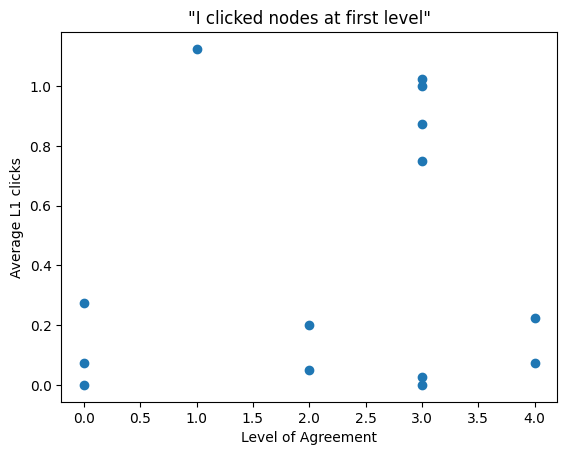

In [156]:
print(strategy_ans_df["Q0"].corr(strategy_ans_df["cL1_mean"]))
plt.scatter(strategy_ans_df["Q0"], strategy_ans_df["cL1_mean"])
plt.title("\"I clicked nodes at first level\"")
plt.xlabel("Level of Agreement")
plt.ylabel("Average L1 clicks")
plt.show()

In [113]:
strategy_ans_df["Q4"].value_counts().sort_index()

Q4
0.0    5
1.0    4
2.0    3
4.0    2
Name: count, dtype: int64

In [156]:
strategy_ans_df.where(strategy_ans_df > 2, 100)

,Q0,Q1,Q2,Q3,Q4,cL1_mean
0,3.0,100.0,100.0,100.0,3.0,100.00
1,3.0,100.0,3.0,100.0,3.0,100.00
2,100.0,100.0,3.0,100.0,100.0,100.00
3,4.0,100.0,4.0,4.0,100.0,100.00
4,3.0,100.0,100.0,3.0,100.0,100.00
5,3.0,100.0,100.0,3.0,100.0,100.00
6,100.0,100.0,100.0,100.0,100.0,100.00
8,4.0,100.0,3.0,100.0,3.0,100.00
9,100.0,3.0,100.0,4.0,4.0,100.00
10,100.0,100.0,100.0,3.0,100.0,100.00


In [165]:
agreement_df == 2

,Q0,Q1,Q2,Q3,Q4,cL1_mean
0,False,False,False,False,False,False
1,False,False,False,False,False,False
2,False,False,False,False,True,False
3,False,False,False,False,False,False
4,False,False,False,False,False,False
5,False,False,False,False,True,False
6,False,False,False,False,False,False
8,False,True,False,False,False,False
9,False,False,False,False,False,False
10,False,False,False,False,False,False


In [172]:
agreement_df = strategy_ans_df.copy()
agreement_df = agreement_df.where(agreement_df >= 2, -1)
agreement_df = agreement_df.where(agreement_df <= 2, 1)
agreement_df = agreement_df.where(agreement_df != 2, 0)
agreement_df["cL1_mean"] = strategy_ans_df["cL1_mean"]

agreement_df

,Q0,Q1,Q2,Q3,Q4,cL1_mean
0,1.0,-1.0,-1.0,-1.0,1.0,0.12
1,1.0,-1.0,1.0,-1.0,1.0,0.36
2,-1.0,-1.0,1.0,-1.0,0.0,0.04
3,1.0,-1.0,1.0,1.0,-1.0,1.96
4,1.0,-1.0,-1.0,1.0,-1.0,0.00
5,1.0,-1.0,-1.0,1.0,0.0,0.60
6,-1.0,-1.0,-1.0,-1.0,-1.0,0.00
8,1.0,0.0,1.0,-1.0,1.0,0.00
9,-1.0,1.0,-1.0,1.0,1.0,0.28
10,-1.0,-1.0,-1.0,1.0,-1.0,0.00


In [176]:
(agreement_df["Q1"] + agreement_df["Q2"]).value_counts()

 0.0    13
-2.0    10
-1.0     4
 1.0     2
Name: count, dtype: int64

In [85]:
correct_answers = {
    "Q0": "$-2 to $2",
    "Q1": "$-16 to $16",
    "Q2": "$-88 to $88"
}

num_correct = {}
questions_correct = {}
bonus = {}

for cond in conditions.keys():
    num_correct[cond] = []
    questions_correct[cond] = {
        "Q0": 0,
        "Q1": 0,
        "Q2": 0
    }
    bonus[cond] = []
    sub_df = complete_data.loc[complete_data.condition == cond]
    for idx, row in sub_df.iterrows():
        part = [p for p in part_stats_dicts if p["workerId"] == row["workerId"]][0]
        part_answers = part['final_quiz_responses']
        part_correct_answers = sum([part_answers[key] == correct_answers[key] for key in correct_answers.keys()])
        num_correct[cond].append(part_correct_answers)
        for q in correct_answers.keys():
            questions_correct[cond][q] += int(part_answers[q] == correct_answers[q])
        part_bonus = full_bonus_eligible.loc[full_bonus_eligible.workerId == row["workerId"]].bonus.values[0]
        bonus[cond].append(part_bonus)



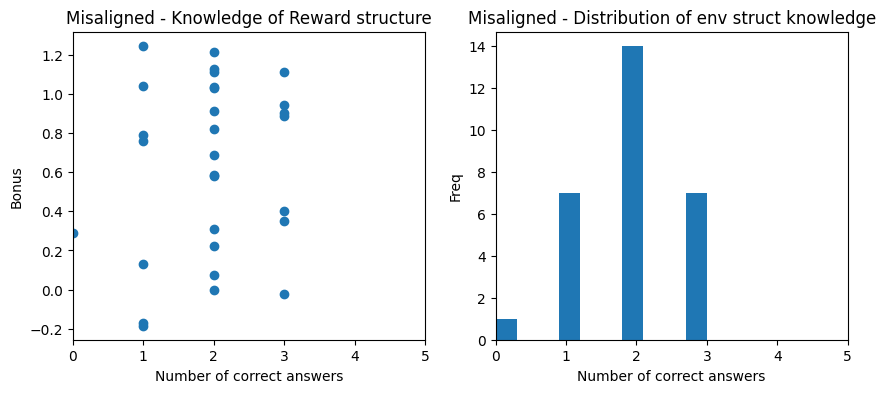

In [86]:


for idx, (cond, condname) in enumerate(conditions.items()):
    plt.figure(figsize=(5 * 2,4 * len(conditions)))
    plt.subplot(1,2,1)
    plt.scatter(num_correct[cond], bonus[cond])
    plt.xlabel("Number of correct answers")
    plt.ylabel("Bonus")
    plt.title(f"{condname} - Knowledge of Reward structure")
    plt.xlim([0,5])
    plt.subplot(1,2,2)
    plt.hist(num_correct[cond])
    plt.xlabel("Number of correct answers")
    plt.ylabel("Freq")
    plt.xlim([0,5])
    plt.title(f"{condname} - Distribution of env struct knowledge")

plt.show()

In [87]:
questions_correct

{0: {'Q0': 20, 'Q1': 13, 'Q2': 23}}